# BigDIPA 2017:  Spatial Statistics with Python

**A tutorial using Python to calculate spatial statistics.**

By [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)<br/>
Department of Computer Science<br/>
University of California, Irvine

September 20, 2017

## Outline
-------------------------
Point processes are quite general models of points in space and/or time and are useful for analyzing a range of observed phenomenom.  In this lab, we study three types of processes: homogeneous and non- Poisson processes, clustering processes, and repellant processes.  We also cover how to compute so-called G-statistics for a point process in order to test if the points are uniform, clustered, or repellant.   

The lab consists of three parts:
### Part 1:  Model Definitions
- Define Poisson process and simulate data from one.
- Define clustering and repellant processes as extensions of a Poisson process.  
- Plot data from various processes.

### Part 2:  Testing for Process Type 
- Define and calculate the G statistic.
- Implement replication to perform hypothesis test.

### Part 3:  Application to Protein Data
- Load and visualize protein dataset
- Test if points exhibit cohesion, repulsion, or neither.

## References
----------------------------------
[Analysing spatial point patterns in R](http://www2.stat.unibo.it/bruno/dati%20spaziali%200809/spatialpointpatterns.pdf) : Description and implementation in R of the discussed methods. 

## Import Packages
-----------------------------

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#  PART 1:  Point Process Models
--------------------

For a product space $\mathcal{X} \times \mathcal{Y}$, define a Poisson process over the space as:

$$n \sim Poisson(\lambda_{0} \mid \mathcal{X} \times \mathcal{Y} \mid)$$ 

$$u_{i} \sim Uniform(\mathcal{X} \times \mathcal{Y}) \ \ \ for \ \ i \in [1, n]$$

where $\mid \mathcal{X} \times \mathcal{Y} \mid$ denotes the volume of the space.  In words, we first sample $n$ points from a Poisson distribution whose intensity is the base intensity $\lambda_{0}$ scaled by the volume of the space.  Notice that the Poisson intensity paramter, $\lambda_{0}$, is fixed across the space.  Thus we call the process **homogeneous**.  If $\lambda$, rather, varies according to some function $\lambda = f(x,y)$, we call the process **non-homogeneous**.  Next we'll implement a function that can sample from both types of processes.      

## 1.1  Sample from a Poisson Process

In [2]:
# 10 X 10 
nX = 10
nY = nX

# Generate the same data by setting the seed
np.random.seed(135)

def sample_from_poisson_process(intensity=1., nonhomog_fn=None, xMin=0., yMin=0., xMax=nX, yMax=nY, step_size=1.):
    
    ### Homogeneous process
    if nonhomog_fn is None:
        # draw uniformly over the area
        n = np.random.poisson( intensity * (xMax - xMin)*(yMax - yMin) )
        return np.hstack([np.random.uniform(low=xMin, high=xMax, size=(n,1)), np.random.uniform(low=yMin, high=yMax, size=(n,1))])
    
    ### Non-Homogenous process defined by nonhomog_fn(x, y, step_size)
    else:
        sample_aggregator = []
        # for simplicity, we'll simulate from a patch work of homogenous PPs
        for y in np.arange(yMin, yMax, step_size):
            for x in np.arange(xMin, xMax, step_size):
                
                samples = sample_from_poisson_process(nonhomog_fn(x, y, step_size), xMin=0., yMin=0., xMax=step_size, yMax=step_size)
                samples[:,0] = samples[:,0] + x
                samples[:,1] = samples[:,1] + y
                sample_aggregator.append(samples)
                
        return np.vstack(sample_aggregator)    

The above function defines the non-homogeneous process via a discrete patchwork of homogeneous ones.  We did this for simplicity, but more sophisticated techniques, such as [Gaussian Processses](https://hips.seas.harvard.edu/files/adams-sgcp-icml-2009.pdf), can be used to define the intensity as a continuous function.  

## 1.2  Plot Non- and Homogeneous Processes

First, let's define a function for the non-homogenous process.

In [3]:
def intensity_fn(x, y, step_size):
    if x == y:
        return 25.
    else:
        return 1.

Simulate data from both types of Poisson processes.

In [4]:
x_homog_pp = sample_from_poisson_process(intensity=5.)
x_nonhomog_pp = sample_from_poisson_process(nonhomog_fn=intensity_fn)

Plot the two processes.

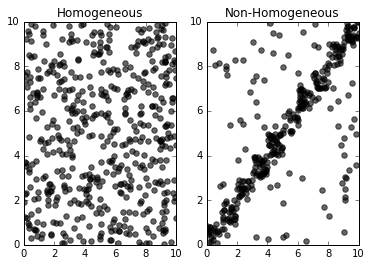

In [5]:
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(x_homog_pp[:,0], x_homog_pp[:,1], s=30, color='black', alpha=0.6)
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(x_nonhomog_pp[:,0], x_nonhomog_pp[:,1], s=30, color='black', alpha=0.6)
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.title("Non-Homogeneous")

plt.show()

## 1.3  Poisson Cluster Process

Notice that the Poisson process---both types---samples points independently.  Even in the non-homogeneous type, the intensity depends on the location in space, and the points are conditionally independent, given the location.  Next we look at point processes with inter-point dependence.  Define a *Poisson cluster process*, with parameters $\lambda_{0}$, $\lambda_{1}$, and $\sigma_{0}$, as follows: 

$$ \{ u_{i} \} \sim Poisson \ Process(\lambda_{0}) $$
$$ n_{i} \sim Poisson(\lambda_{1}) $$
$$ \{ u_{i,j} \} \sim \text{Normal}(\mu=u_{i}, \sigma_{0}) \ \ \ for \ \ j \in [1, n_{i}]$$

The final sample set consists of both the parent and child points: $ \{ \{ u_{i} \}, \{ u_{i,j} \} \} $.  In words, this process simply samples points from a homogeneous Poisson process, and then for each sampled point, it samples child point from a Normal distribution centered at the parent point.  Let's define the child generator...

In [6]:
def sample_child_point(x0, cluster_intensity=1., gauss_scale=.1):
    n = np.random.poisson(cluster_intensity)
    if n < 1: return None
    
    samples = []
    for i in range(n):
        samples.append( x0 + np.random.normal(scale=gauss_scale, size=(1,2)) )
    
    return np.vstack(samples)

Now let's use the child generator to sample a full cluster process...

In [7]:
### Sample parent points from Poisson process
homog_pp = sample_from_poisson_process(intensity=1.)

### Sample child points
candidates = [sample_child_point(homog_pp[i]) for i in range(homog_pp.shape[0])]
child_points = np.vstack([x for x in candidates if x is not None])

### Combine for final sample set
cluster_process = np.vstack([homog_pp, child_points])

Plot the parent and child points separately...

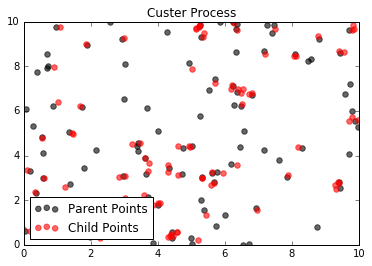

In [8]:
plt.figure()

plt.scatter(homog_pp[:,0], homog_pp[:,1], s=30, color='black', alpha=0.6, label="Parent Points")
plt.scatter(child_points[:,0], child_points[:,1], s=30, color='red', alpha=0.6, label="Child Points")

plt.xlim([0,nX])
plt.ylim([0,nX])
plt.legend(loc=3)
plt.title("Custer Process")

plt.show()

## 1.4  Repulsive Process

For our final point process, consider the **Matern Model**.  Similarly to the cluster process, we'll sample from a homogeneous Poisson process and then perform a second-step involving the parent points.  This time, instead of adding points, we'll simply remove any points that occur within a distance $r$ of a previously sampled one.  Define *Matern($\lambda_{0}$, $r$)* as... 

$$ \{ u_{i} \} \sim Poisson \ Process(\lambda_{0}) $$
$$ \textbf{remove} \ \  u_{i} \ \ if  \ \ \mid \mid u_{i} - u_{j} \mid \mid_{2} \le r \ \ for \ any \ \ j < i$$

Now let's define the thinning method...

In [9]:
def thin_process(data, radius=.75):
    X = np.array(data)
    
    test_idx = X.shape[0]-1
    while test_idx > 0:
        for idx in range(test_idx):
            
            if np.sqrt(np.sum((X[test_idx] - X[idx])**2)) <= radius:
                X = np.delete(X, test_idx, 0)
                break  # we've found one point that satisfies, no need to test others
                
        test_idx -= 1
    return X

Let's sample from the process...

In [10]:
repulsed_process = thin_process(homog_pp)

Plot the original and final points...

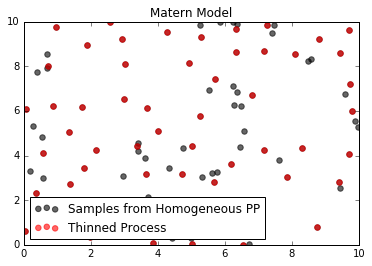

In [11]:
plt.figure()
plt.scatter(homog_pp[:,0], homog_pp[:,1], s=30, color='black', alpha=0.6, label="Samples from Homogeneous PP")
plt.scatter(repulsed_process[:,0], repulsed_process[:,1], s=30, color='red', alpha=0.6, label="Thinned Process")
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.legend(loc=3)
plt.title("Matern Model")

plt.show()

# PART 2:  Testing Observed Data
--------------------

Having defined the above processes, now let's consider the scenario in which we have observed data and want to test if it originated from a homogeneous process, a clustering process, or a repellant process.  To do this, we'll use the **G function** (see *Baddeley 15.3.1*), which is defined as follows:

$$ G(\mathbf{X}, r) = \frac{1}{N_{X}} \sum_{i=1}^{N_{X}} \mathbb{1}[ t_{i} \le r ] $$

where $r$ is a distance parameter and $t_{i} = \min \mid \mid u_{i} - u_{j} \mid \mid_{2}$.  Or in words, $t_{i}$ is the distance from $u_{i}$ to its nearest neighbor.

Let's implement the G function...

In [12]:
def calculate_emp_G_statistic(data, radius=1.):
    
    n = data.shape[0]
    dist_tests = [0.] * n
    
    for i in range(n):
        for j in range(n):
            
            # skip if same point or if we already found the dist satisfied
            if i == j or dist_tests[j] == 1: continue 
            
            euc_dist = np.sqrt(np.sum((data[i] - data[j])**2))
            if euc_dist <= radius:
                dist_tests[i] = 1.
                dist_tests[j] = 1.
                break
                
    return np.sum(dist_tests)/n

## 2.1  Asymptotic G-Function

If the data is truly from a Poisson process, the G statistic has an asymptotic form, given as follows 

$$ G_{poisson}(\lambda, r) = 1 - e^{-\lambda \pi r^{2}} .$$ 

We can use this formula for observed data if we use an empirical estimate for the intensity:

$$ \hat{\lambda} = \mid \mathbf{X} \mid / \mid \mathcal{X} \times \mathcal{Y} \mid $$ where $\mid \mathbf{X} \mid$ is the number of observations and $\mid \mathcal{X} \times \mathcal{Y} \mid$ is the volume of the space.

In [13]:
def calculate_emp_intensity(data):
    # assumes a square region
    return data.shape[0]/((np.max(data[:,0])-np.min(data[:,0]))*(np.max(data[:,1])-np.min(data[:,1])))


def calculate_poisson_G_statistic(data, radius=1.):   
    
    # get emp. intensity
    emp_intensity = calculate_emp_intensity(data)        
    
    # asymptotic formula
    return 1 - np.exp(-emp_intensity * np.pi * radius**2)

Now let's calculate the empirical and asympotic G statistics for a range of $r$ values...

In [14]:
radii = np.arange(0., 1.25, .25)

g_data = []
g_poisson = []
for data in [homog_pp, cluster_process, repulsed_process]:
    
    # calculate G-function on data
    g_data.append([calculate_emp_G_statistic(data, radius=r) for r in radii])
    
    # calculate G-function as if the data were a homogeneous PP
    g_poisson.append([calculate_poisson_G_statistic(data, radius=r) for r in radii])

Plot the curves for each point process type...

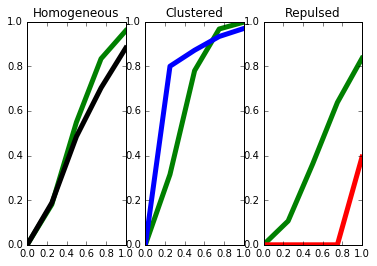

In [15]:
### Make Plots
ax1 = plt.subplot(1, 3, 1)
ax1.plot(radii, g_poisson[0],'g-', linewidth=5.)
ax1.plot(radii, g_data[0],'k-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 3, 2)
ax2.plot(radii, g_poisson[1],'g-', linewidth=5.)
ax2.plot(radii, g_data[1],'b-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Clustered")

ax3 = plt.subplot(1, 3, 3)
ax3.plot(radii, g_poisson[2],'g-', linewidth=5.)
ax3.plot(radii, g_data[2],'r-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Repulsed")

plt.show()

Observe that the curves are biased downward.  This is from the censoring that occurs at the boundaries of the space.  See *Baddeley 15.3.1* (Equation 19) for discussion of edge correction methods.

## 2.2  Monte Carlo Envelope Tests

While the above method---comparing empirical and asymptotic G-functions---suggests the process' characteristics, it doesn't provide a clear, stastically-sound decision, such as a hypothesis test would provide.  Here we perform such a test, called a *Monte Carlo Envelope Test* (see *Baddeley 16*).  Note this is **NOT** a Neyman-Pearson confidence interval.  Rather, the test is based off the [*Monte Carlo test principle*](https://perso.univ-rennes1.fr/jian-feng.yao/pedago/mcmc/Hope.pdf).  Intuitively, what we're going to do is simulate data that agrees with the null hypothesis (homogeneous points) and see if the observed data has similar G statistics.  

The procedure is as follows.  First, we decide on the number of replications based off our desired test level according to the formula 

$$ \alpha = \frac{2}{M+1}. $$  Thus, if we desire the usual $\alpha = 0.05$, we need to perform $M=39$ replications.

In [16]:
### M=39 so that alpha = 0.05
n_replications = 39

Next we sample $M$ datasets $\mathbf{X}_{m}$, eaching containing the same number of data points as in the observation set, i.e. $$\mathbf{X}_{m} = \{x_{1},..., x_{n} \} \sim Uniform(\mid \mathcal{X} \times \mathcal{Y} \mid).$$  We then calculate the G-function for several $r$ values for each dataset, i.e. $ \hat{G}(\mathbf{X}_{m}, r)$.  Lastly, we find the extreme values of $\hat{G}(\mathbf{X}_{m}, r)$ (across $m$) for each radius value.  Mathematically, we have bounds $[L(r), U(r)]$ given by $$ L(r) = \min_{m} \  \hat{G}(\mathbf{X}_{m}, r) \ \ \ \text{ and } \ \ \  U(r) = \max_{m} \  \hat{G}(\mathbf{X}_{m}, r).$$

Let's implement the procedure...

In [17]:
g_maxs = []
g_mins = []

for data in [homog_pp, cluster_process, repulsed_process]:
    
    n = data.shape[0]
    
    temp_list = []
    # Calculate G stat under repeated sampling from PP with emp intensity
    for i in range(n_replications):
        temp_list.append([calculate_emp_G_statistic(np.random.uniform(low=0, high=nX, size=(n,2)), radius=r) for r in radii])

    # Compute mean and std of replications    
    temp_list = np.array( temp_list )
    g_maxs.append( np.max(temp_list, axis=0) )
    g_mins.append( np.min(temp_list, axis=0) )

Plot the results...

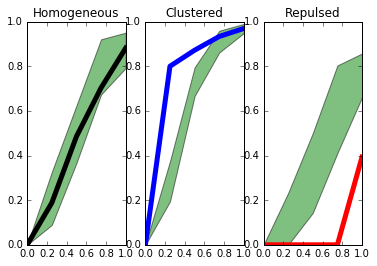

In [18]:
### Make Plots
ax1 = plt.subplot(1, 3, 1)
ax1.fill_between(radii, g_mins[0], g_maxs[0], facecolor='green', interpolate=True, alpha=.5)
ax1.plot(radii, g_data[0],'k-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 3, 2)
ax2.fill_between(radii, g_mins[1], g_maxs[1], facecolor='green', interpolate=True, alpha=.5)
ax2.plot(radii, g_data[1],'b-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Clustered")

ax3 = plt.subplot(1, 3, 3)
ax3.fill_between(radii, g_mins[2], g_maxs[2], facecolor='green', interpolate=True, alpha=.5)
ax3.plot(radii, g_data[2],'r-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Repulsed")

plt.show()

We see that the data generated from a homogeneous Poisson process falls within the green bands and the others don't.  Thus we can say the second exihibts statistically significantly more clustering than a homogeneous process and the other significantly less.

# PART 3:  Application to Protein Dataset
--------------------

Now let's apply these techniques to a real dataset.  [This paper](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005095) generated a point process dataset using microscopy to measure the placement of proteins (and lipids) on a cell surface.  Whether the proteins are clustered or not has biological consequence, being evidence of polarization, endocytosis, and intracellular signaling.  Your task to to find out what type of distribution the points follow: clustered, homogeneous, or repulsive.  To do this, you'll need to
1.  Visualize the data and a homogeneous Poisson process estimated from data
2.  Plot the G-function vs the asymptotic G-function for a homogeneous process
3.  Perform the Monte Carlo envelope test and produce the appropraite plot

Let's load the data... 

In [19]:
protein_data = np.loadtxt(open("spatial_data/protein_locations.csv", "rb"), delimiter=",", skiprows=1)
xMax, xMin = (np.max(protein_data[:,0]), np.min(protein_data[:,0])) 
yMax, yMin = (np.max(protein_data[:,1]), np.min(protein_data[:,1])) 

print protein_data

[[ 125.99   157.81 ]
 [ 120.7    168.99 ]
 [ 117.12   165.34 ]
 [ 122.51   174.84 ]
 [ 129.19   167.11 ]
 [ 103.71   187.79 ]
 [ 113.71   162.61 ]
 [ 110.79   174.36 ]
 [ 108.05   176.28 ]
 [ 101.31   171.99 ]
 [ 113.88   163.5  ]
 [ 117.35   172.7  ]
 [ 126.45   180.87 ]
 [ 101.58   183.3  ]
 [ 103.2    186.56 ]
 [ 118.83   179.9  ]
 [ 108.11   161.57 ]
 [ 115.48   177.73 ]
 [ 106.12   158.78 ]
 [ 112.03   154.8  ]
 [ 111.54   179.01 ]
 [ 100.58   158.54 ]
 [ 107.74   181.95 ]
 [ 111.73   181.31 ]
 [ 120.83   177.36 ]
 [ 114.79   174.04 ]
 [ 102.68   166.47 ]
 [ 111.39   172.01 ]
 [ 110.57   178.87 ]
 [ 124.01   180.4  ]
 [ 110.8    179.57 ]
 [ 124.2    167.88 ]
 [ 105.62   177.53 ]
 [  96.21   172.43 ]
 [ 113.53   180.87 ]
 [ 119.13   184.98 ]
 [ 117.54   171.92 ]
 [ 129.85   165.85 ]
 [ 111.6    162.9  ]
 [ 111.91   154.62 ]
 [ 104.02   186.63 ]
 [ 104.4    163.27 ]
 [ 123.76   173.91 ]
 [ 113.23   178.73 ]
 [ 116.32   178.83 ]
 [ 111.62   166.35 ]
 [ 100.03   178.84 ]
 [ 106.85   1

## 3.1  Plot the Data and Estimated Poisson Process

First, estimate the intensity parameter from the data and then sample from a corresponding poisson process...

In [20]:
### Your code here ###

estimated_lambda = calculate_emp_intensity(protein_data)

est_poisson_process = sample_from_poisson_process(intensity=estimated_lambda, xMin=xMin, xMax=xMax, yMin=yMin, yMax=yMax)

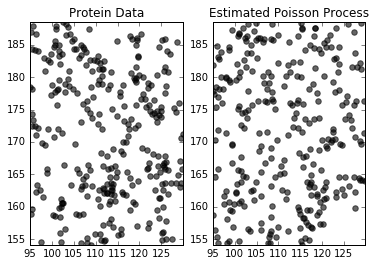

In [21]:
### Your code for plotting goes here ###

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(protein_data[:,0], protein_data[:,1], s=30, color='black', alpha=0.6)
plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])
plt.title("Protein Data")

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(est_poisson_process[:,0], est_poisson_process[:,1], s=30, color='black', alpha=0.6)
plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])
plt.title("Estimated Poisson Process")

plt.show()

## 3.2  Plot Empirical G-Function vs Asymptotic G-Function

Calculate the empirical and asymptotic G function for various $r$ values, as we did above...

In [22]:
radii = np.arange(0., 3.5, .5)

### Your code goes here ###

# calculate G-function on data
g_data = [calculate_emp_G_statistic(protein_data, radius=r) for r in radii]
    
# calculate G-function as if the data were a homogeneous PP
g_poisson = [calculate_poisson_G_statistic(protein_data, radius=r) for r in radii]

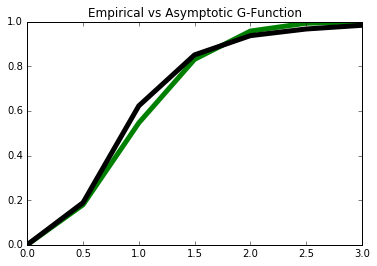

In [23]:
### Make Plot ###
plt.figure()

plt.plot(radii, g_poisson,'g-', linewidth=5.)
plt.plot(radii, g_data,'k-', linewidth=5.)

plt.xlim([0,3.])
plt.ylim([0,1.])
plt.title("Empirical vs Asymptotic G-Function")

plt.show()

## 3.3  Perform Envelope Test

Lastly, perform the Monte Carlo envelope test...

In [24]:
n = protein_data.shape[0]
n_replications = 39

### Your code goes here ###

temp_list = []
# Calculate G stat under repeated sampling from PP with emp intensity
for i in range(n_replications):
    simulated_data = np.hstack([np.random.uniform(low=xMin, high=xMax, size=(n,1)), np.random.uniform(low=yMin, high=yMax, size=(n,1))])
    temp_list.append([calculate_emp_G_statistic(simulated_data, radius=r) for r in radii])

# Compute mean and std of replications    
temp_list = np.array( temp_list )

g_maxs = np.max(temp_list, axis=0) 
g_mins = np.min(temp_list, axis=0) 

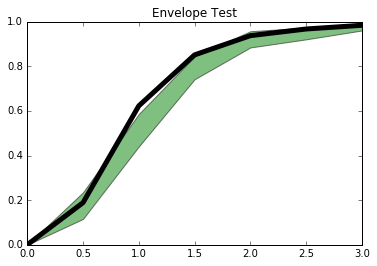

In [25]:
### Make Plot
plt.figure()

plt.fill_between(radii, g_mins, g_maxs, facecolor='green', interpolate=True, alpha=.5)
plt.plot(radii, g_data,'k-', linewidth=5.)

plt.xlim([0,3.])
plt.ylim([0,1.])
plt.title("Envelope Test")

plt.show()

## 3.4  More Data, Open Problem...

You'll find three more datasets in the data directory.  They contain the activation patterns of Stellate Ganglia in three mice numbered 1, 2, and 5.  Some questions one might ask: does one mouse exhibit more clustering than another?  Are there common aspects to their clustering?  One difficulty is that the coordinates are not necessarily standardized across the three datasets, and thus one must use coordinate invariant statistics for analysis.  Luckily, the G function, as it only measures inter-point distance, is coordinate invariant.     

We load the three datasets below and visualize them...

In [26]:
mouse_data1 = np.loadtxt(open("spatial_data/mouse1_SG_L_W_data.csv", "rb"), delimiter=",", skiprows=1)[:,:2]
mouse_data2 = np.loadtxt(open("spatial_data/mouse2_SG_L_W_data.csv", "rb"), delimiter=",", skiprows=1)[:,:2]
mouse_data5 = np.loadtxt(open("spatial_data/mouse5_SG_L_W_data.csv", "rb"), delimiter=",", skiprows=1)[:,:2]

xMax1, xMin1, yMax1, yMin1 = (np.max(mouse_data1[:,0]), np.min(mouse_data1[:,0]), np.max(mouse_data1[:,1]), np.min(mouse_data1[:,1])) 
xMax2, xMin2, yMax2, yMin2 = (np.max(mouse_data2[:,0]), np.min(mouse_data2[:,0]), np.max(mouse_data2[:,1]), np.min(mouse_data2[:,1]))
xMax5, xMin5, yMax5, yMin5 = (np.max(mouse_data5[:,0]), np.min(mouse_data5[:,0]), np.max(mouse_data5[:,1]), np.min(mouse_data5[:,1]))

print mouse_data1

[[ 1091.4    903.28]
 [ 1066.7   1087.8 ]
 [ 1164.2   1056.7 ]
 [ 1121.1   1197.4 ]
 [ 1213.    1132.4 ]
 [ 1015.    1189.  ]
 [ 1250.5   1029.9 ]
 [ 1207.4   1160.7 ]
 [ 1162.1   1139.5 ]
 [ 1177.7   1187.5 ]
 [ 1022.8   1059.6 ]
 [ 1230.7   1089.3 ]
 [ 1250.5   1056.7 ]
 [ 1247.7   1121.8 ]
 [ 1163.5   1167.7 ]
 [  803.62   823.38]
 [ 1085.    1203.8 ]
 [ 1141.6   1079.4 ]
 [  996.66   954.2 ]
 [ 1012.2   1027.7 ]
 [ 1021.4   1126.  ]
 [ 1078.7   1132.4 ]
 [ 1051.8   1101.3 ]
 [ 1267.5   1080.8 ]
 [ 1271.7   1053.9 ]
 [ 1197.5   1138.  ]
 [ 1106.3   1229.3 ]
 [  848.17   858.03]
 [  887.06   918.13]
 [  933.73  1162.8 ]
 [  964.84  1117.5 ]
 [  840.39   906.82]
 [ 1218.7   1041.9 ]
 [ 1239.2   1148.6 ]
 [ 1225.8   1122.5 ]
 [ 1219.4   1171.3 ]
 [ 1275.3    992.38]
 [ 1143.     984.6 ]
 [ 1121.1    949.95]
 [ 1060.3    985.31]
 [ 1154.3    860.15]
 [ 1105.6    866.51]
 [ 1030.6    859.44]
 [ 1260.4   1011.5 ]
 [ 1242.     956.32]
 [ 1119.7   1073.  ]
 [ 1138.1   1050.4 ]
 [ 1181.9   1

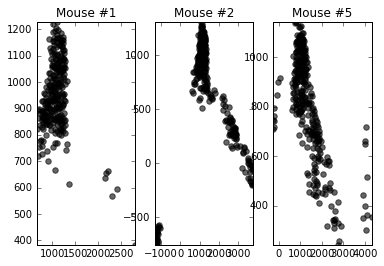

In [27]:
ax1 = plt.subplot(1, 3, 1)
ax1.scatter(mouse_data1[:,0], mouse_data1[:,1], s=30, color='black', alpha=0.6)
plt.xlim([xMin1,xMax1])
plt.ylim([yMin1,yMax1])
plt.title("Mouse #1")

ax2 = plt.subplot(1, 3, 2)
ax2.scatter(mouse_data2[:,0], mouse_data2[:,1], s=30, color='black', alpha=0.6)
plt.xlim([xMin2,xMax2])
plt.ylim([yMin2,yMax2])
plt.title("Mouse #2")

ax3 = plt.subplot(1, 3, 3)
ax3.scatter(mouse_data5[:,0], mouse_data5[:,1], s=30, color='black', alpha=0.6)
plt.xlim([xMin5,xMax5])
plt.ylim([yMin5,yMax5])
plt.title("Mouse #5")

plt.show()